# PINN applied to a PDE

The PDE we are considering is
$$\begin{cases}u_{tt}=c^2 u_{xx}+f(x,t) \\ u(x,0)=6e^{-3x} \end{cases}$$
on the domain $[0,2]\times[0,1]$ (space $\times$ time).

In [1]:
import numpy as np

import torch
import torch.nn as nn
from torch.autograd import Variable

In [2]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

We considere Net as the solution $u_\theta(x,t)$.

We have to keep the number of imputs (2, $(x,t)$) and outputs (1, $u(x,t)$). However we can add many hidden layers as we want with as many neurons. More complex the net, the more aproximate solution we obtain (its require more data).

In [4]:
class Net(nn.Module):
    def __init__(self, num_layers, num_neurons):
        super(Net, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(2, num_neurons))
        for i in range(num_layers - 1):
            self.layers.append(nn.Linear(num_neurons, num_neurons))
        self.output_layer = nn.Linear(num_neurons, 1)

    def forward(self, x, t):
        inputs = torch.cat([x,t],axis=1) # combined two arrays of 1 columns each to one array of 2 columns
        out = inputs
        for layer in self.layers:
            out = torch.sigmoid(layer(out))
        output = self.output_layer(out) ## For regression, no activation is used in output layer
        return output

Create the model with num_laers and num_neurons.

In [5]:
### (2) Model
net = Net(num_layers=10, num_neurons=5)
net = net.to(device)

In [6]:
# loss function and optimizer
mse_cost_function = torch.nn.MSELoss() # Mean squared error
optimizer = torch.optim.Adam(net.parameters())

The PDE as loss function. 

In [11]:
def f(x,t,c,net):
    u = net(x,t)
    u_x = torch.autograd.grad(u.sum(), x, create_graph=True)[0]
    u_t = torch.autograd.grad(u.sum(), t, create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x.sum(), x, create_graph=True)[0]
    u_tt = torch.autograd.grad(u_t.sum(), t, create_graph=True)[0]
    f_val = u_tt - c**2 * u_xx
    return f_val.sum()

Let's create data from the BC $u(x,0)=6e^{-3x}$.

In [12]:
n_t = 500
x_bc = np.random.uniform(low=0.0, high=2.0, size=(n_t,1))
t_bc = np.zeros((n_t,1))
# compute u based on BC
u_bc = 6*np.exp(-3*x_bc)
c = 1.0

In [13]:
### (3) Training / Fitting
iterations = 20000
previous_validation_loss = 99999999.0
for epoch in range(iterations):
    optimizer.zero_grad() # to make the gradients zero
    
    # Loss based on boundary conditions
    pt_x_bc = Variable(torch.from_numpy(x_bc).float(), requires_grad=False).to(device)
    pt_t_bc = Variable(torch.from_numpy(t_bc).float(), requires_grad=False).to(device)
    pt_u_bc = Variable(torch.from_numpy(u_bc).float(), requires_grad=False).to(device)
    
    net_bc_out = net(pt_x_bc, pt_t_bc) # output of u(x,t)
    mse_u = mse_cost_function(net_bc_out, pt_u_bc)
    
    # Loss based on PDE
    x_collocation = np.random.uniform(low=0.0, high=2.0, size=(500,1))
    t_collocation = np.random.uniform(low=0.0, high=1.0, size=(500,1))
    all_zeros = np.zeros((500,1))
    
    
    pt_x_collocation = Variable(torch.from_numpy(x_collocation).float(), requires_grad=True).to(device)
    pt_t_collocation = Variable(torch.from_numpy(t_collocation).float(), requires_grad=True).to(device)
    pt_all_zeros = Variable(torch.from_numpy(all_zeros).float(), requires_grad=False).to(device)
    
    f_out = f(pt_x_collocation, pt_t_collocation, c, net) # output of f(x,t)
    mse_f = mse_cost_function(f_out, pt_all_zeros)
    
    # Combining the loss functions
    loss = mse_u + mse_f
    
    
    loss.backward() # This is for computing gradients using backward propagation
    optimizer.step() # This is equivalent to : theta_new = theta_old - alpha * derivative of J w.r.t theta

    with torch.autograd.no_grad():
    	print(epoch,"Traning Loss:",loss.data)

c:\Users\Det-Pc\anaconda3\envs\pytorch-C-DL\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([500, 1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


0 Traning Loss: tensor(3.8490, device='cuda:0')
1 Traning Loss: tensor(3.8373, device='cuda:0')
2 Traning Loss: tensor(3.8257, device='cuda:0')
3 Traning Loss: tensor(3.8141, device='cuda:0')
4 Traning Loss: tensor(3.8026, device='cuda:0')
5 Traning Loss: tensor(3.7911, device='cuda:0')
6 Traning Loss: tensor(3.7797, device='cuda:0')
7 Traning Loss: tensor(3.7683, device='cuda:0')
8 Traning Loss: tensor(3.7570, device='cuda:0')
9 Traning Loss: tensor(3.7457, device='cuda:0')
10 Traning Loss: tensor(3.7345, device='cuda:0')
11 Traning Loss: tensor(3.7234, device='cuda:0')
12 Traning Loss: tensor(3.7123, device='cuda:0')
13 Traning Loss: tensor(3.7012, device='cuda:0')
14 Traning Loss: tensor(3.6902, device='cuda:0')
15 Traning Loss: tensor(3.6793, device='cuda:0')
16 Traning Loss: tensor(3.6685, device='cuda:0')
17 Traning Loss: tensor(3.6577, device='cuda:0')
18 Traning Loss: tensor(3.6469, device='cuda:0')
19 Traning Loss: tensor(3.6362, device='cuda:0')
20 Traning Loss: tensor(3.6256

In [14]:
from mpl_toolkits import mplot3d

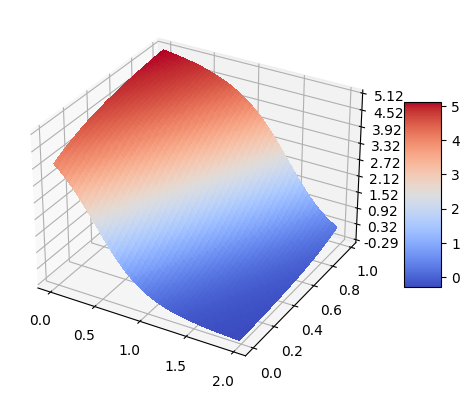

In [15]:
fig = plt.figure()
# ax = fig.gca(projection='3d')
ax = fig.add_subplot(111, projection='3d')

x=np.arange(0,2,0.02)
t=np.arange(0,1,0.02)
ms_x, ms_t = np.meshgrid(x, t)
## Just because meshgrid is used, we need to do the following adjustment
x = np.ravel(ms_x).reshape(-1,1)
t = np.ravel(ms_t).reshape(-1,1)

pt_x = Variable(torch.from_numpy(x).float(), requires_grad=True).to(device)
pt_t = Variable(torch.from_numpy(t).float(), requires_grad=True).to(device)
pt_u = net(pt_x,pt_t)
u=pt_u.data.cpu().numpy()
ms_u = u.reshape(ms_x.shape)

surf = ax.plot_surface(ms_x,ms_t,ms_u, cmap=cm.coolwarm,linewidth=0, antialiased=False)
             
             

ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()